In [1]:
from SAM_DINO_Functions import *

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


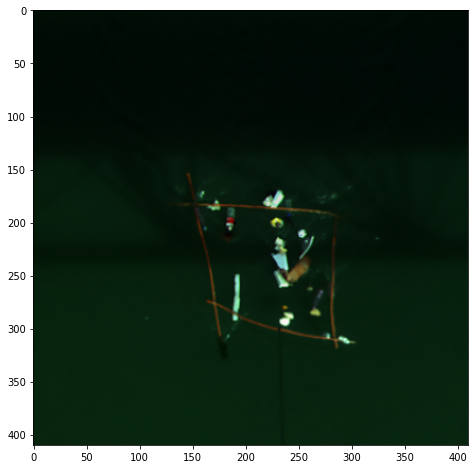

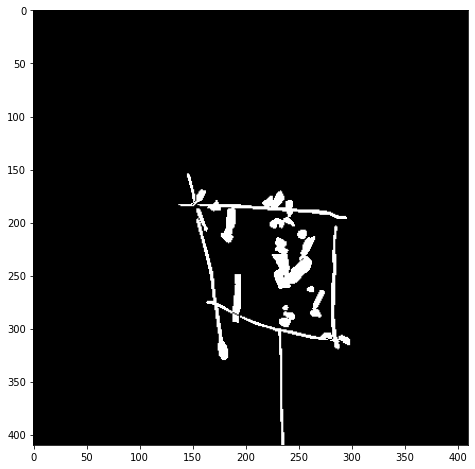

In [2]:
# Define image and segmentartion ground truth image's path
original_image_dir = "images/litter_mon.tiff"
GT_dir = 'images/GT_litter_mon.png'

# Read the image ground truth
GT = cv2.imread(GT_dir)
GT = cv2.cvtColor(GT, cv2.COLOR_BGR2GRAY)

# Convert the ground truth mask to binary image
# Needed for segmentation evaluation
_, GT = cv2.threshold(GT, 1, 255, cv2.THRESH_BINARY)
GT = GT.astype(bool)

# Read the 3 channels image
img = cv2.imread(original_image_dir)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plot the image & ground truth
plt.figure(figsize = (12,8))
plt.imshow(img)
plt.figure(figsize = (12,8))
plt.imshow(GT, cmap = 'gray')

In [4]:
img.shape, img.shape[0] * img.shape[1]

((410, 410, 3), 168100)

## Segment Anything Model (SAM) model

In [5]:
# Insert the path to SAM files and modules
HOME = "/home/arbash44/coding/dino_seg/seg_everything/segment_anything"
%cd {HOME} 

/home/arbash44/coding/dino_seg/seg_everything/segment_anything


In [6]:
# Import SAM modules
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# define SAM training checkpoint and model type
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

# Select inference device: cuda for the GPU
device = "cuda"

# Load SAM model and send it to GPU
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate=none)
        )
      )
      (1): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bia

In [7]:
# Define the mask generator with the preferred hyperparameters
mask_generator = SamAutomaticMaskGenerator(sam,
                                           points_per_side = 128,
                                           points_per_batch = 128,
                                           pred_iou_thresh = 0.8,
                                           stability_score_thresh = 0.7,
                                           stability_score_offset = 1.0,
                                           box_nms_thresh = 0.7,
                                           crop_n_layers = 0,
                                           crop_nms_thresh = 0.7,
                                           crop_overlap_ratio = 512 / 1500,
                                           crop_n_points_downscale_factor = 1,
                                           point_grids = None,
                                           min_mask_region_area = 0)

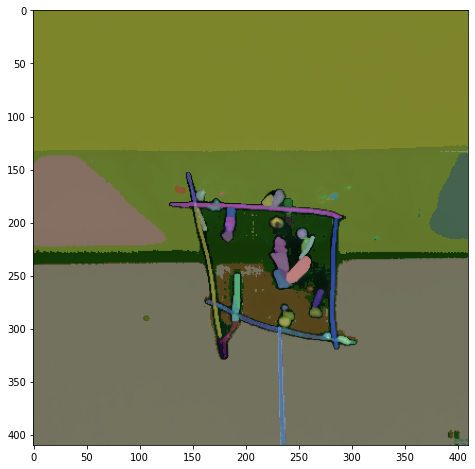

In [8]:
# Generate masks of the input image
masks = mask_generator.generate(img)

# Plot image and the generated masks
plt.figure(figsize=(12,8))
plt.imshow(img)
show_anns(masks)

## Grounding dino model

In [9]:
# Set up the paths to Grounding dino files and modules path
sys.path.append('/home/arbash44/coding/dino_seg/dino/GroundingDINO') 

# Import the Grounding dino's modules
from groundingdino.util.inference import load_model, load_image, predict, annotate

/opt/conda/lib/python3.8/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)


In [10]:
# Set up the paths to Grounding dino's model
HOME = "/home/arbash44/coding/dino_seg/dino"
CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)

# Load Grounding dino's model
model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/opt/conda/lib/python3.8/site-packages/torch/functional.py:598: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2323.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializin

/home/arbash44/.local/lib/python3.8/site-packages/transformers/modeling_utils.py:830: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
2023-06-29 15:37:13.055080: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


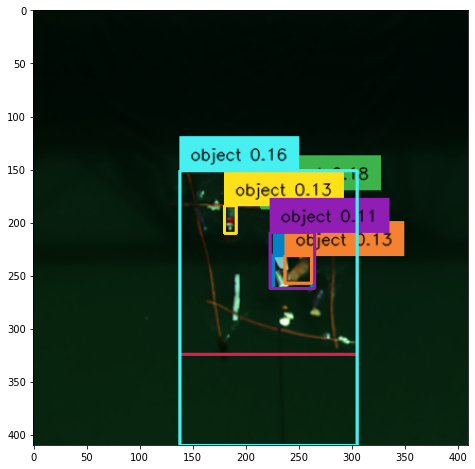

In [11]:
# Provide the path of the input image to Grounding dino
IMAGE_NAME = "/home/arbash44/coding/dino_seg/seg_everything/segment_anything/Ramses/Nina_files/session_002_007_refcorr_rgb.tiff"

# provide the text prompt and hyperparameters
TEXT_PROMPT = "object"
BOX_TRESHOLD = 0.1
TEXT_TRESHOLD = 0.1

# Load the image using Grounding dino loading module
image_source, image = load_image(IMAGE_NAME)

# Perform Grounding dino's prediction
boxes, l, p = predict(
    model=model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)

# Plot the predicted bounding boxes, text and score on the input image
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=l, phrases=p)

# Perform colour conversion
annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)

# Plot the results
plt.figure(figsize = (12,8))
plt.imshow(annotated_frame)

In [12]:
# Filter SAM's prediction
new_masks = intersection_filtering(masks,boxes,img, Max_area = 1000)

# Generate Final mask
final_mask = mask_generation(new_masks)

# Check dimensions
final_mask.shape, img.shape

((410, 410), (410, 410, 3))

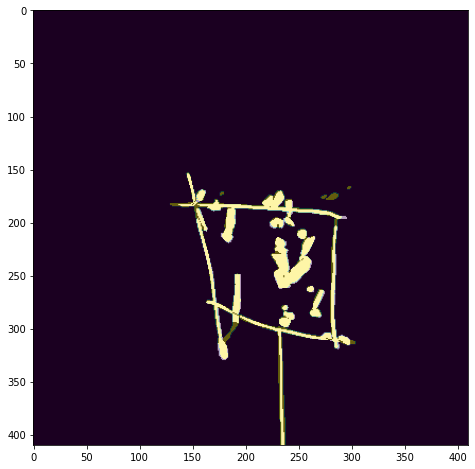

In [13]:
# Plot the final mask on top of the ground truth image
plt.figure(figsize=(12,8))
plt.imshow(GT,cmap = 'gray')
plt.imshow(final_mask,alpha = 0.4)


In [12]:
# Extract segmentation evaluation metrics
confusion_matrix_sum, true_positive_sum, true_negative_sum, false_positive_sum, \
false_negative_sum, precision, recall, f1_score, pixel_accuracy_per_class,      \
pixel_accuracy, iou, dice_coefficient, kappa = evaluate_segmentation(GT, final_mask, 2)

# Print the evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix_sum)
print("Pixel Accuracy:")
print(pixel_accuracy)
print("Precision:")
print(precision)
print("Recall:")
print(recall)
print("F1 Score:")
print(f1_score)
print("Intersection over Union (IoU):")
print(iou)
print("Dice Coefficient:")
print(dice_coefficient)
print("Kappa Coefficient:")
print(kappa)

Confusion Matrix:
[[162087   1277]
 [   360   4376]]
Pixel Accuracy:
0.990261748958953
Precision:
[0.99778389 0.77410225]
Recall:
[0.9921831  0.92398649]
F1 Score:
[0.99497561 0.84242949]
Intersection over Union (IoU):
[0.99000147 0.72775653]
Dice Coefficient:
[0.99497561 0.84242949]
Kappa Coefficient:
[0.74126266 0.98998226]


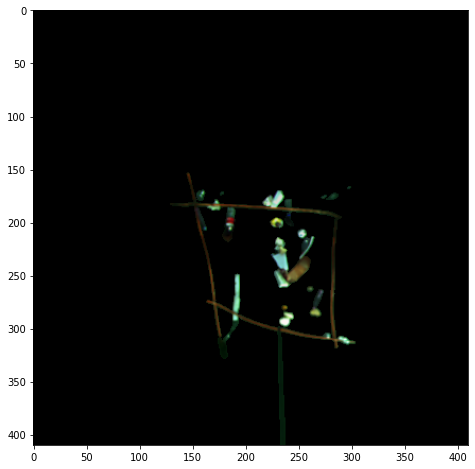

In [13]:
# Creating the masked HSI
img[~final_mask] = 0

# Plotting the masked HSI
plt.figure(figsize = (12,8))
plt.imshow(img)